<a href="https://colab.research.google.com/github/sfwtopoulos/stocks/blob/master/Stocks_seq_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q talos

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 109.2MB 66kB/s 
     |████████████████████████████████| 8.7MB 42.7MB/s 
     |████████████████████████████████| 378kB 44.9MB/s 
     |████████████████████████████████| 3.2MB 33.5MB/s 
     |████████████████████████████████| 491kB 45.3MB/s 
     |████████████████████████████████| 839kB 41.6MB/s 
ERROR: wrangle 0.6.7 has requirement scipy==1.2, but you'll have scipy 1.4.1 which is incompatible.


In [2]:
pip install -q wget

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
import numpy as np
import time
import sys

import pandas_datareader as pdr
#%tensorflow_version 2.x
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
import keras


# from keras.layers import LSTM
# from keras.models import Sequential
# from keras.layers.wrappers import TimeDistributed
# from keras.layers.wrappers import TimeDistributed
# from keras.layers.core import Dense, Activation, Dropout
# from keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers.wrappers import TimeDistributed
from tensorflow.python.keras.layers.wrappers import TimeDistributed
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

import os
import wget
from zipfile import ZipFile

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# from keras.optimizers import Adam, Nadam
# from keras.activations import softmax
# from keras.losses import categorical_crossentropy, logcosh
# from talos.utils import lr_normalizer
import talos
from tensorflow.python.keras.optimizers import Adam, Nadam
from tensorflow.python.keras.activations import softmax
from tensorflow.python.keras.losses import categorical_crossentropy, logcosh
from talos.utils import lr_normalizer

In [5]:
print(keras.__version__)
print(tf.__version__)
#print(tensorflow.compat.v2.__version__)

2.3.0
1.15.2


In [37]:
#Flag to select the small or the large dataset from the git repo
large=True;

if not large:
  #Small Dataset
  #Data import from git repo
  print("Small Dataset Loading")
  url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined.csv'
  #df1 = pd.read_csv(url, error_bad_lines=False)
  dfstocks = pd.read_csv(url, sep=',')
  dfstocks=dfstocks.rename({' AAPL':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);
else:
  #Large Dataset
  print("Large Dataset Loading")
  url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined_large.zip'
  wget.download(url, '.')
  # Create a ZipFile Object and load sample.zip in it
  with ZipFile('combined_large.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
  print(os.listdir("."))
  dfstocks = pd.read_csv('combined_large.csv', sep=',') 
  dfstocks=dfstocks[~dfstocks.Date.str.contains("nan")]
  dfstocks=dfstocks[~dfstocks.Date.str.contains("Low")]
  dfstocks=dfstocks[~dfstocks.Date.str.contains("N/A")]
  dfstocks=dfstocks[~dfstocks.Date.str.contains("date")]
  dfstocks.Date=pd.to_datetime(dfstocks.Date)
  dfstocks['Date'] = dfstocks['Date'].dt.strftime('%Y-%m-%d')
  dfstocks=dfstocks.rename({' AA':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);

Large Dataset Loading
['.config', 'combined_large.csv', 'combined_large (1).zip', 'gdrive', 'combined_large.zip', 'sample_data']


In [38]:
type(dfstocks['Date'])
dfstocks.dtypes

Date       object
Close      object
Volume     object
Open       object
High       object
Low        object
Company    object
dtype: object

In [39]:
for col in dfstocks.columns: 
    print(col) 

Date
Close
Volume
Open
High
Low
Company


In [40]:
dfstocks

,Date,Close,Volume,Open,High,Low,Company
0,2018-02-11,36.93000031,2681700,37,37.68999863,36.40999985,AA
1,2018-01-11,36.77999878,2756200,35.43999863,36.88000107,35.24000168,AA
2,2018-10-31,34.99000168,3380700,34.81999969,35.82099915,34.59999847,AA
3,2018-10-30,34.15000153,2193400,33.65000153,34.47999954,33.4129982,AA
4,2018-10-29,33.81999969,2219600,34.59999847,35.11999893,33.40000153,AA
...,...,...,...,...,...,...,...
304988,1973-09-05,0.469444454,79200,0.469444454,0.48888889,0.469444454,USB
304989,1973-08-05,0.469444454,90000,0.469444454,0.480555564,0.469444454,USB
304990,1973-07-05,0.461111099,43200,0.469444454,0.480555564,0.461111099,USB
304991,1973-04-05,0.469444454,10800,0.469444454,0.480555564,0.469444454,USB


In [0]:
#drop $sign from values
dfstocks.Close=dfstocks['Close'].astype(str)
dfstocks.Close=dfstocks.Close.apply(lambda x: x.replace('$',''))
dfstocks.Open=dfstocks['Open'].astype(str)
dfstocks.Open=dfstocks.Open.apply(lambda x: x.replace('$',''))
dfstocks.High=dfstocks['High'].astype(str)
dfstocks.High=dfstocks.High.apply(lambda x: x.replace('$',''))
dfstocks.Low=dfstocks['Low'].astype(str)
dfstocks.Low=dfstocks.Low.apply(lambda x: x.replace('$',''))

In [42]:
#drop rows containing nan or header from the csv files
dfstocks=dfstocks[~dfstocks.Low.str.contains("nan")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("Low")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("N/A")]
dfstocks=dfstocks[~dfstocks.Volume.str.contains("N/A")]
dfstocks.reset_index(drop=True, inplace=True)
dfstocks.Date.count()

304968

In [43]:
#sort dataframe based on date and Company Name
dfstocks = dfstocks.sort_values(['Date', 'Company'])
dfstocks.head(100)

,Date,Close,Volume,Open,High,Low,Company
12261,1970-01-04,7.116885185,70500,7.116885185,7.148924828,7.116885185,AA
34140,1970-01-04,6.664636612,75300,6.664636612,6.71148777,6.664636612,ARNC
81366,1970-01-04,12.53962517,18500,12.50450039,12.57474995,12.50450039,CNP
93689,1970-01-04,0.775599957,2628200,0.75762248,0.778168142,0.74734962,DIS
141068,1970-01-04,0.776041687,5068800,0.76953125,0.779947937,0.76953125,GE
...,...,...,...,...,...,...,...
250575,1970-01-13,5.757882118,99200,5.757882118,5.77859354,5.716458321,MRO
12314,1970-01-14,6.808499813,57900,6.85656023,6.85656023,6.808499813,AA
34193,1970-01-14,6.371814251,61800,6.442091465,6.442091465,6.371814251,ARNC
81419,1970-01-14,10.95899963,24400,11.0994997,11.0994997,10.95899963,CNP


In [44]:
#Converting Datatypes
dfstocks.Date=pd.to_datetime(dfstocks.Date)
dfstocks.Close=pd.to_numeric(dfstocks.Close)
dfstocks.Volume=pd.to_numeric(dfstocks.Volume)
dfstocks.Open=pd.to_numeric(dfstocks.Open)
dfstocks.High=pd.to_numeric(dfstocks.High)
dfstocks.Low=pd.to_numeric(dfstocks.Low)
dfstocks.dtypes

Date       datetime64[ns]
Close             float64
Volume              int64
Open              float64
High              float64
Low               float64
Company            object
dtype: object

In [0]:
#Company Chosen
comp="AAPL"

In [76]:
#dfstocks[dfstocks['Company'].str.contains("AMZN")]
sub_split=dfstocks[dfstocks['Company'].str.contains(comp)]
sub_split.isnull().values.any()
sub_split.isna().values.any()
sub_split = sub_split.sort_values(['Date'])
sub_split.reset_index(drop=True, inplace=True)
sub_split.shape[0]

9556

In [0]:
#Run only if you want to have a subset hidden from talos
#hidden split for validation
hidden_split=sub_split[(sub_split['Date'].dt.year==2018) | (sub_split['Date'].dt.year==2017) | (sub_split['Date'].dt.year==2016)]

#drop hidden_split from sub_split 
sub_split=sub_split[sub_split['Date'].dt.year < 2016]
hidden_split

In [0]:
#TEST HIDDEN
#hidden split for validation
# hidden_split=sub_split[(sub_split['Date'].dt.year==2018) | (sub_split['Date'].dt.year==2017) | (sub_split['Date'].dt.year==2016)]

#drop hidden_split from sub_split 
sub_split=sub_split[(sub_split['Date'].dt.year < 2016) & (sub_split['Date'].dt.year > 2009)]
#sub_split=sub_split[(sub_split['Date'].dt.year < 2016) & (sub_split['Date'].dt.year > 2014)]
# sub_split

In [90]:
sub_split

,Volume,Close,Open,High,Low,scaled1,scaled2,scaled3,scaled4,scaled5
8588,40621400,124.250000,124.820000,125.120003,123.099999,0.184869,0.707162,0.756504,0.657579,0.789340
8589,58512600,128.949997,126.099999,130.130005,125.300003,0.304815,0.864458,0.788835,0.839695,0.845178
8590,32112800,130.539993,130.279999,131.389999,130.050003,0.127825,0.917670,0.894418,0.885496,0.965736
8591,30238800,126.599999,126.900001,126.940002,125.989998,0.115262,0.785810,0.809043,0.723737,0.862690
8592,76845900,107.720001,110.150001,111.879997,107.360001,0.427726,0.153949,0.385956,0.176300,0.389848
...,...,...,...,...,...,...,...,...,...,...
8835,13570400,108.029999,109.000000,109.000000,107.949997,0.003513,0.164324,0.356908,0.071610,0.404822
8836,26704200,106.820000,107.589996,107.690002,106.180000,0.091565,0.123829,0.321293,0.023991,0.359899
8837,30931200,108.739998,106.959999,109.430000,106.860001,0.119904,0.188086,0.305380,0.087241,0.377157
8838,25213800,107.320000,108.580002,108.699997,107.180000,0.081573,0.140562,0.346300,0.060705,0.385279


In [0]:
# prepare training and testing data sets for LSTM based sequence modeling
#def dimitris_function(time_series, scaling=True,split_ratio=0.9):
def dimitris_function(time_series,split_ratio=0.9):

    series1 = pd.Series(time_series[time_series.columns[0]])
    series2 = pd.Series(time_series[time_series.columns[1]])
    series3 = pd.Series(time_series[time_series.columns[2]])
    series4 = pd.Series(time_series[time_series.columns[3]])
    series5 = pd.Series(time_series[time_series.columns[4]])

    values1 = series1.values
    values1 = values1.reshape((len(values1), 1))
    values2 = series2.values
    values2 = values2.reshape((len(values2), 1))
    values3 = series3.values
    values3 = values3.reshape((len(values3), 1))
    values4 = series4.values
    values4 = values4.reshape((len(values4), 1))
    values5 = series5.values
    values5 = values5.reshape((len(values5), 1))

    #scaler2 --> Close Price Scaler
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled1"] = scaler1.fit_transform(values1)
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled2"]= scaler2.fit_transform(values2)
    scaler3 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled3"]= scaler3.fit_transform(values3)
    scaler4 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled4"]= scaler4.fit_transform(values4)
    scaler5 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled5"]= scaler5.fit_transform(values5)


    time_series = time_series[["scaled1","scaled2","scaled3","scaled4","scaled5"]].values

        
    split_ratio = int(len(time_series) * split_ratio)

    train = time_series[0:split_ratio]
    test = time_series[split_ratio:len(time_series)-1]
    
    # return train,test,scaler1,scaler2
    return train,test,scaler2


In [22]:
#mounting gdrive to save talos results for each run and tensor flow checkpoints
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#def get_seq_model(hidden_units1=40, hidden_units2=65, hidden_units3=32, drop=0.2,input_shape=(1,1)):
def get_seq_model(x_train, y_train, x_val, y_val, params):  

    # create and fit the LSTM network
    model = Sequential()

    print(params)
    print(type(params))

    # samples*timesteps*features
    # https://keras.io/getting-started/sequential-model-guide/
    #https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227222

    ######!!!!!#####!!!!!
    #(train_x.shape[1],5) where 5 is the number of features is equal to :
    #(train_x.shape[1],train_x.shape[2])
    model.add(LSTM(
                   input_shape=(x_train.shape[1],x_train.shape[2]),
                   units = params['hidden_1'],  
                   #activation='relu',recurrent_activation='sigmoid',
                   return_sequences=True
    ))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(
                   units = params['hidden_2'],
                   #activation='relu',recurrent_activation='sigmoid',
                   return_sequences=True
    ))
    model.add(Dropout(params['dropout']))   
    model.add(LSTM(
                   units = params['hidden_3'], 
                   #activation='relu',recurrent_activation='sigmoid',
                   return_sequences=True
    ))
    model.add(Dropout(params['dropout']))

    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    # model.add(TimeDistributed(Dense(1))) #number of inputs in the 1st layer
   # model.add(TimeDistributed(Dense(5)))
    model.add(TimeDistributed(Dense(5)))
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")
    timestr = time.strftime("%Y%m%d-%H%M%S")
    checkpoint_path = "/content/gdrive/My Drive/checkpoints1"  + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True,#save_best_only='TRUE'
        # Save weights, every 5-epochs.
        period=15)
    
   # early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
    
    out = model.fit(x_train, y_train,
              epochs=params['epochs'], batch_size=1,
              validation_data=[x_val, y_val],
              #epochs=200, batch_size=1,
              verbose=1,callbacks=[cp_callback])

    return out, model

In [24]:
ls gdrive/"My Drive"/checkpoints1

checkpoint                        cp-0060.ckpt.data-00000-of-00002
cp-0015.ckpt.data-00000-of-00002  cp-0060.ckpt.data-00001-of-00002
cp-0015.ckpt.data-00001-of-00002  cp-0060.ckpt.index
cp-0015.ckpt.index                cp-0075.ckpt.data-00000-of-00002
cp-0030.ckpt.data-00000-of-00002  cp-0075.ckpt.data-00001-of-00002
cp-0030.ckpt.data-00001-of-00002  cp-0075.ckpt.index
cp-0030.ckpt.index                cp-0090.ckpt.data-00000-of-00002
cp-0045.ckpt.data-00000-of-00002  cp-0090.ckpt.data-00001-of-00002
cp-0045.ckpt.data-00001-of-00002  cp-0090.ckpt.index
cp-0045.ckpt.index


In [0]:
talos=False;

if not talos:
  #Chosen final parameters
  p = {'hidden_1': 8,
     'hidden_2': 16,
     'hidden_3': 32,
     'dropout': 0.1,
     'epochs': 100
     }

else:
  #Parameters for the model optimization in talos
  p = {'hidden_1':[8, 16, 32],
     'hidden_2':[8, 16, 32],
     'hidden_3':[8, 16, 32],
     'dropout': [0.1, 0.2],
     #'dropout': [0.1],
     'epochs': [20, 50, 100]
     }

In [0]:
# print(type(sub_split.Close))
sub_split_date=sub_split[['Date']]
sub_split=sub_split[['Volume', 'Close', 'Open', 'High', 'Low']]
#sub_split.columns[1]

In [82]:
# split train and test datasets
train,test,scaler_Close = dimitris_function(sub_split,split_ratio=0.7)

#train
print(len(train))
print(train.shape[0])
print(train.shape)
print(test.shape)
# print(train)

176
176
(176, 5)
(75, 5)


In [83]:
#We use numpy to reshape our time series into 3D tensors.
train = np.reshape(train,(train.shape[0],1,5))
test = np.reshape(test,(test.shape[0],1,5))

train_x = train[:,:,:]
train_y = train[:,:,:]

test_x = test[:,:,:]
test_y = test[:,:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(176, 1, 5)
train_y shape=(176, 1, 5)
test_x shape=(75, 1, 5)
test_y shape=(75, 1, 5)


In [84]:
load_from_checkpoint=True;

seq_lstm_model=None
if load_from_checkpoint:
  #Load the latest checkpoint saved in Drive #'gdrive/My Drive/checkpoints1/cp-0090.ckpt'
  latest=tf.train.latest_checkpoint("gdrive/My Drive/checkpoints1")
  print(latest)
  #Create the model and train for 1 epoch to get the NN stracture
  p['epochs']=1
  try:
    seq_lstm_model=get_seq_model(train_x,train_y,test_x,test_y,p)
  except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(train_x,train_y,test_x,test_y,p)
  #Load the weight of the checkpoint to the NN 
  seq_lstm_model[1].load_weights(latest)
else:
  # build RNN model
  try:
    seq_lstm_model = get_seq_model(train_x,train_y,test_x,test_y,p)
  except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(train_x,train_y,test_x,test_y,p)

gdrive/My Drive/checkpoints1/cp-0090.ckpt
{'hidden_1': 8, 'hidden_2': 16, 'hidden_3': 32, 'dropout': 0.1, 'epochs': 1}
<class 'dict'>
Train on 176 samples, validate on 75 samples
176/176 [==============================] - 6s 33ms/sample - loss: 0.1459 - val_loss: 0.0400


In [0]:
# x=np.concatenate((train_x, test_x), axis=1)
# y=np.concatenate((train_y, test_y), axis=1)
# print("x shape={}".format(x.shape))
# print("y shape={}".format(y.shape))
import talos


In [0]:
%%capture
# 100	0.0005776109765	0.001970537574	0.1	100	8	16	32
scan_obj = talos.Scan(x=train_x,
                      y=train_y,
                      x_val=test_x,
                      #x_val=train_x,
                      y_val=test_y,
                     #y_val=train_y,

                      params=p,
                      val_split=0.1,
                      model=get_seq_model,
                      #shuffle=False,
                      experiment_name='gdrive/My Drive/test',
                      #fraction_limit=0.1
                      )


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
print("Finished Talos Scan!!")

In [0]:
scan_obj.data.head()

In [0]:
# train_y

In [0]:
# train the model
#https://medium.com/@rajath95/how-to-save-and-upload-deep-learning-machine-learning-models-in-google-colab-using-google-drive-eb2901937ae
# seq_lstm_model[1].fit(train_x, train_y,
#                 epochs=2, batch_size=1,
#                 #epochs=200, batch_size=1,
#                 verbose=1)
# print("Model Fit Complete")

In [85]:
# train fit performance
trainPredict = seq_lstm_model[1].predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

# Pad input sequence
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')

# forecast values
testPredict = seq_lstm_model[1].predict(testPredict)
testPredict

Train Score: 0.16 RMSE


array([[[0.01492372, 0.38674444, 0.3829521 , 0.38026303, 0.38941127]],

       [[0.01465006, 0.4182907 , 0.41411126, 0.4113884 , 0.42095098]],

       [[0.01457324, 0.43565586, 0.43126816, 0.4285255 , 0.4383117 ]],

       [[0.01492513, 0.3659451 , 0.36240613, 0.35974735, 0.36860597]],

       [[0.01488403, 0.33374542, 0.33060664, 0.32799673, 0.33638793]],

       [[0.01467261, 0.3863024 , 0.38250747, 0.37982193, 0.38897172]],

       [[0.01460176, 0.37052995, 0.36692303, 0.36425614, 0.3732057 ]],

       [[0.01444239, 0.39780286, 0.39385772, 0.39115417, 0.40049216]],

       [[0.01464106, 0.38130665, 0.37757212, 0.37489527, 0.3839726 ]],

       [[0.01484906, 0.38726947, 0.3834679 , 0.3807807 , 0.38993412]],

       [[0.01463046, 0.36838448, 0.36480457, 0.3621409 , 0.37105802]],

       [[0.0147482 , 0.32252485, 0.31952977, 0.31693834, 0.32515237]],

       [[0.01466623, 0.31915557, 0.31619906, 0.31360275, 0.3217984 ]],

       [[0.0154009 , 0.43610284, 0.4317627 , 0.4289952 , 0.43875

In [0]:
# print()

In [0]:
# trainPredict

In [0]:
# # forecast values
# testPredict = seq_lstm_model[1].predict(testPredict)
# testPredict

In [0]:
#Drop all other variables except Close Price Output
testPredict=np.delete(testPredict, [2,3,4], 2)
trainPredict=np.delete(trainPredict, [2,3,4], 2)

testPredict=np.delete(testPredict, 0, 2)
trainPredict=np.delete(trainPredict, 0, 2)

# # inverse transformation of the Close Price
trainPredict = scaler_Close.inverse_transform(trainPredict.\
                                        reshape(-1,1))
testPredict = scaler_Close.inverse_transform(testPredict.\
                                       reshape(-1,1))

In [0]:
# testPredict

In [0]:
# trainPredict

In [0]:
# # # inverse transformation of the Close Price
# trainPredict = scaler_Close.inverse_transform(trainPredict.\
#                                         reshape(-1,1))
# testPredict = scaler_Close.inverse_transform(testPredict.\
#                                        reshape(-1,1))

In [0]:
# trainPredict

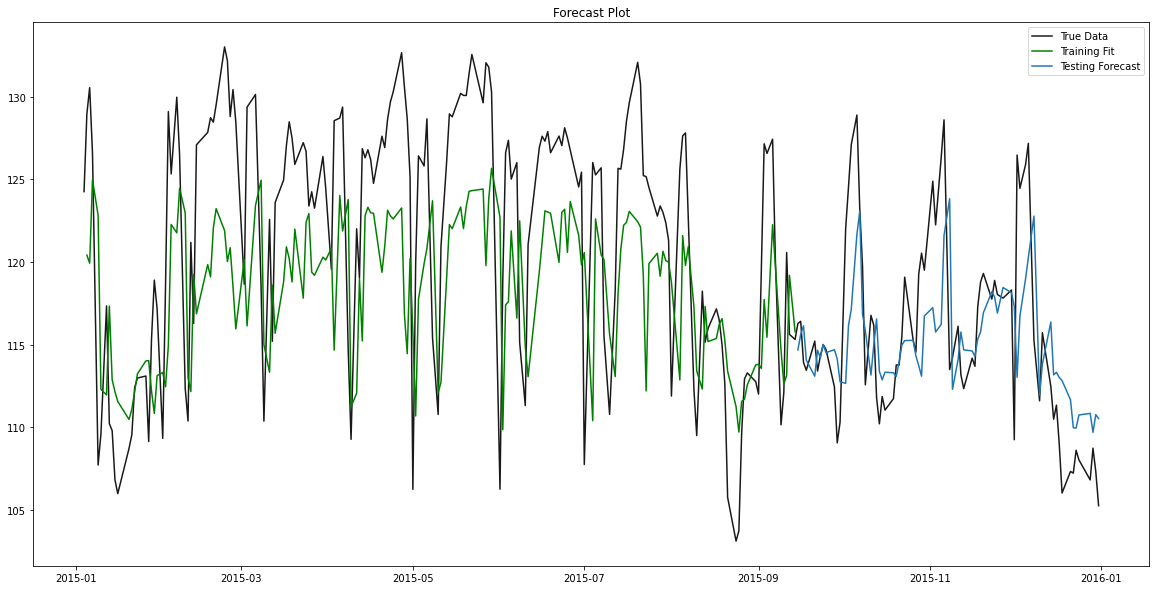

In [89]:
# plot the true and forecasted values
split_ratio = len(trainPredict)+1

plt.plot(sub_split_date.Date,
          sub_split.Close.values,c='black',
          alpha=0.9,label='True Data')

plt.plot(sub_split_date.Date[1:split_ratio],
          trainPredict,label='Training Fit',c='g')

# plt.plot(sub_split_date.Date[split_ratio+1:],
#           testPredict[:test_x.shape[1]],label='Testing Forecast')

plt.plot(sub_split_date.Date[split_ratio:],
          testPredict[:test_x.shape[0]],label='Testing Forecast')

plt.title('Forecast Plot')
plt.legend()
#plt.show()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()